# Draw an isochrone map with OSMnx

Author: [Geoff Boeing](https://geoffboeing.com/)

How far can you travel on foot in 15 minutes?

  - [Overview of OSMnx](http://geoffboeing.com/2016/11/osmnx-python-street-networks/)
  - [GitHub repo](https://github.com/gboeing/osmnx)
  - [Examples, demos, tutorials](https://github.com/gboeing/osmnx-examples)
  - [Documentation](https://osmnx.readthedocs.io/en/stable/)
  - [Journal article/citation](http://geoffboeing.com/publications/osmnx-complex-street-networks/)

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import osmnx as ox
from descartes import PolygonPatch
from shapely.geometry import Point, LineString, Polygon
import shapely
from shapely import MultiPolygon

In [147]:
import pandas as pd
import numpy as np
from tqdm import tqdm

In [2]:
import warnings
warnings.simplefilter("ignore")

In [51]:
# configure the place, network type, trip times, and travel speed
network_type = 'walk'
trip_times = [5, 10, 15, 20] #in minutes
travel_speed = 4 #walking speed in km/hour

In [61]:
# get one color for each isochrone
iso_colors = ox.plot.get_colors(n=len(trip_times), cmap='plasma', start=0)

## Getting data

In [148]:
metro_df = pd.read_csv('data/metro-exits-2024-12-18.csv', delimiter=';')
del metro_df['Unnamed: 21']
metro_df.head()

,Локальный идентификатор,Наименование,На территории Москвы,Административный округ,Район,Долгота в WGS-84,Широта в WGS-84,Тип вестибюля,Станция метрополитена,Линия,...,Режим работы по чётным дням,Режим работы по нечётным дням,Количество полнофункциональных БПА (все типы билетов),Количество малофункциональных БПА (билеты на 1 и 2 поездки),Общее количество БПА,Ремонт эскалаторов,Статус объекта,global_id,geoData,geodata_center
0,331,"Китай-город, вход-выход 5 в северный вестибюль",да,Центральный административный округ,Басманный район,37.631765,55.757328,подземный,Китай-город,Калужско-Рижская линия,...,открытие в 05:30:00; закрытие в 01:00:00; перв...,открытие в 05:30:00; закрытие в 01:00:00; перв...,NaN,4.0,4.0,nested data,действует,1773539,"{coordinates=[37.63176509, 55.75732811], type=...","{coordinates=[37.63176509, 55.75732811], type=..."
1,327,"Китай-город, вход-выход 4 в северный вестибюль",да,Центральный административный округ,Тверской район,37.630924,55.756733,подземный,Китай-город,Калужско-Рижская линия,...,открытие в 05:30:00; закрытие в 01:00:00; перв...,открытие в 05:30:00; закрытие в 01:00:00; перв...,NaN,4.0,4.0,nested data,действует,1773540,"{coordinates=[37.63092407, 55.75673268], type=...","{coordinates=[37.63092407, 55.75673268], type=..."
2,330,"Китай-город, вход-выход 7 в северный вестибюль",да,Центральный административный округ,Басманный район,37.631862,55.757027,подземный,Китай-город,Калужско-Рижская линия,...,открытие в 05:30:00; закрытие в 01:00:00; перв...,открытие в 05:30:00; закрытие в 01:00:00; перв...,NaN,4.0,4.0,nested data,действует,1773541,"{coordinates=[37.63186197, 55.75702717], type=...","{coordinates=[37.63186197, 55.75702717], type=..."
3,322,"Китай-город, вход-выход 13 в южный вестибюль",да,Центральный административный округ,Тверской район,37.633207,55.752999,подземный,Китай-город,Калужско-Рижская линия,...,открытие в 05:30:00; закрытие в 01:00:00; перв...,открытие в 05:30:00; закрытие в 01:00:00; перв...,NaN,4.0,4.0,nested data,действует,1773542,"{coordinates=[37.63320674, 55.7529987], type=P...","{coordinates=[37.63320674, 55.7529987], type=P..."
4,321,"Китай-город, вход-выход 12 в южный вестибюль",да,Центральный административный округ,Таганский район,37.633566,55.753071,подземный,Китай-город,Калужско-Рижская линия,...,открытие в 05:30:00; закрытие в 01:00:00; перв...,открытие в 05:30:00; закрытие в 01:00:00; перв...,NaN,4.0,4.0,nested data,действует,1773543,"{coordinates=[37.63356616, 55.75307131], type=...","{coordinates=[37.63356616, 55.75307131], type=..."


In [194]:
metro_df = metro_df[metro_df['Линия'] != 'Московская монорельсовая транспортная система']

In [195]:
metro_df['Линия'].value_counts()

Линия
Таганско-Краснопресненская линия    124
Сокольническая линия                122
Калужско-Рижская линия              117
Серпуховско-Тимирязевская линия     117
Замоскворецкая линия                108
Люблинско-Дмитровская линия          99
Большая кольцевая линия              97
Арбатско-Покровская линия            78
Московское центральное кольцо        73
Солнцевская линия                    50
Калининская линия                    39
Некрасовская линия                   32
Кольцевая линия                      30
Филёвская линия                      27
Бутовская линия Лёгкого метро        11
Троицкая линия                       10
Name: count, dtype: int64

In [151]:
metro_df = metro_df.iloc[:, [5, 6, 8, 9]]
metro_df.head()

,Долгота в WGS-84,Широта в WGS-84,Станция метрополитена,Линия
0,37.631765,55.757328,Китай-город,Калужско-Рижская линия
1,37.630924,55.756733,Китай-город,Калужско-Рижская линия
2,37.631862,55.757027,Китай-город,Калужско-Рижская линия
3,37.633207,55.752999,Китай-город,Калужско-Рижская линия
4,37.633566,55.753071,Китай-город,Калужско-Рижская линия


In [152]:
metro_df[metro_df['Станция метрополитена'] == 'Мнёвники'].iloc[:, [0, 1]].mean()

Долгота в WGS-84    37.472022
Широта в WGS-84     55.761102
dtype: float64

In [153]:
metro_df[metro_df['Станция метрополитена'] == 'Мнёвники'].iloc[:, [0, 1]].to_numpy()

array([[37.47138012, 55.76026171],
       [37.47172881, 55.76017096],
       [37.47233066, 55.76200533],
       [37.47264716, 55.76196903]])

In [154]:
stations = list(set([x[0] + '_' + x[1] for x in metro_df.iloc[:, [2, 3]].values.tolist()]))
stations[:5]

['Китай-город_Калужско-Рижская линия',
 'Парк Победы_Солнцевская линия',
 'Народное Ополчение_Большая кольцевая линия',
 'Бибирево_Серпуховско-Тимирязевская линия',
 'Тропарёво_Сокольническая линия']

## Download and prep the street network

In [211]:
station_isochrones = {}

In [324]:
station = stations[50]
# station = 'Мнёвники_Большая кольцевая линия'
# station = 'Ясенево_Калужско-Рижская линия'
station = 'Цветной бульвар_Серпуховско-Тимирязевская линия'
print(station)
st_name, st_line = list(station.split('_'))
coords = metro_df[(metro_df['Станция метрополитена'] == st_name) & (metro_df['Линия'] == st_line)].iloc[:, [0, 1]].mean()
station_coords = coords[1], coords[0]

Цветной бульвар_Серпуховско-Тимирязевская линия


In [325]:
G = ox.graph_from_point(station_coords, dist=travel_speed * 1000 / 60 * 20 + 500, dist_type='network', network_type=network_type, simplify=False)

In [326]:
gdf_nodes = ox.graph_to_gdfs(G, edges=False)
gdf_nodes['geometry'].crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [327]:
crs = "EPSG:4326"
# crs = "EPSG:32637"

exits = metro_df[(metro_df['Станция метрополитена'] == st_name) & (metro_df['Линия'] == st_line)].iloc[:, [0, 1]].to_numpy()

G = ox.project_graph(G, to_crs=crs)
exit_nodes = []
for exit in exits:
    x, y = ox.projection.project_geometry(Point(exit[0], exit[1]), crs="EPSG:4326", to_crs=crs)[0].xy
    exit_node = ox.distance.nearest_nodes(G, x[0], y[0])
    exit_nodes.append(exit_node)

G = ox.project_graph(G)

In [328]:
# add an edge attribute for time in minutes required to traverse each edge
meters_per_minute = travel_speed * 1000 / 60 #km per hour to m per minute
for u, v, k, data in G.edges(data=True, keys=True):
    data['time'] = data['length'] / meters_per_minute

## Or, plot isochrones as buffers to get more faithful isochrones than convex hulls can offer

[<POLYGON ((412432.423 6181099.142, 412430.635 6181100.821, 412429.019 618110...>, <POLYGON ((412649.238 6181239.521, 412648.337 6181239.63, 412648.025 6181239...>, <POLYGON ((412968.053 6181390.214, 412965.761 6181391.089, 412963.566 618139...>, <POLYGON ((413282.322 6181418.926, 413280.352 6181417.464, 413278.247 618141...>]


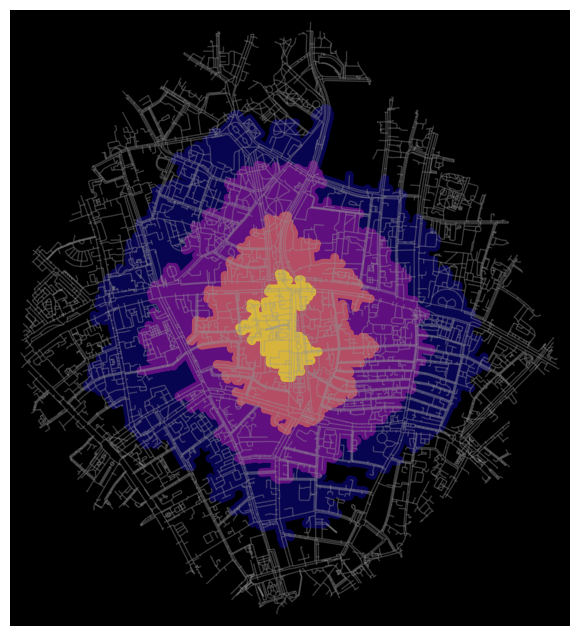

In [329]:
def make_iso_polys(G, center_node, edge_buff=25, node_buff=50, infill=False):
    isochrone_polys = []
    for trip_time in sorted(trip_times, reverse=True):
        subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance='time')

        node_points = [Point((data['x'], data['y'])) for node, data in subgraph.nodes(data=True)]
        nodes_gdf = gpd.GeoDataFrame({'id': subgraph.nodes()}, geometry=node_points)
        nodes_gdf = nodes_gdf.set_index('id')

        edge_lines = []
        for n_fr, n_to in subgraph.edges():
            f = nodes_gdf.loc[n_fr].geometry
            t = nodes_gdf.loc[n_to].geometry
            edge_lookup = G.get_edge_data(n_fr, n_to)[0].get('geometry',  LineString([f,t]))
            edge_lines.append(edge_lookup)

        n = nodes_gdf.buffer(node_buff).geometry
        e = gpd.GeoSeries(edge_lines).buffer(edge_buff).geometry
        all_gs = list(n) + list(e)
        new_iso = gpd.GeoSeries(all_gs).union_all()

        g_node = G.nodes(data=True)[center_node]
        if type(new_iso) != Polygon:
            new_iso = Polygon([(g_node['x'], g_node['y'])]*4)

        # try to fill in surrounded areas so shapes will appear solid and blocks without white space inside them
        if infill:
            new_iso = Polygon(new_iso.exterior)
        isochrone_polys.append(new_iso)
    return isochrone_polys


all_iso_polys = []
for exit_node in exit_nodes:
    isochrone_polys = make_iso_polys(G, exit_node, edge_buff=25, node_buff=0, infill=True)
    print(isochrone_polys)
    all_iso_polys.append(isochrone_polys)

    fig, ax = ox.plot_graph(G, show=False, close=False, edge_color='#999999', edge_alpha=0.2,
                            node_size=0, bgcolor='k')
    for polygon, fc in zip(isochrone_polys, iso_colors):
        patch = PolygonPatch(polygon, fc=fc, ec='none', alpha=0.6, zorder=-1)
        ax.add_patch(patch)
    
    plt.show()

In [330]:
isochrones = []
for i in range(len(trip_times)):
    iso = shapely.union_all([iso_polys[i] for iso_polys in all_iso_polys])
    if type(iso) != MultiPolygon:
        iso = MultiPolygon([iso])
    isochrones.append(iso)
isochrones

[<MULTIPOLYGON (((412432.423 6181099.142, 412430.635 6181100.821, 412429.019 ...>,
 <MULTIPOLYGON (((412649.238 6181239.521, 412648.337 6181239.63, 412648.025 6...>,
 <MULTIPOLYGON (((412968.053 6181390.214, 412965.761 6181391.089, 412963.566 ...>,
 <MULTIPOLYGON (((413282.322 6181418.926, 413280.352 6181417.464, 413278.247 ...>]

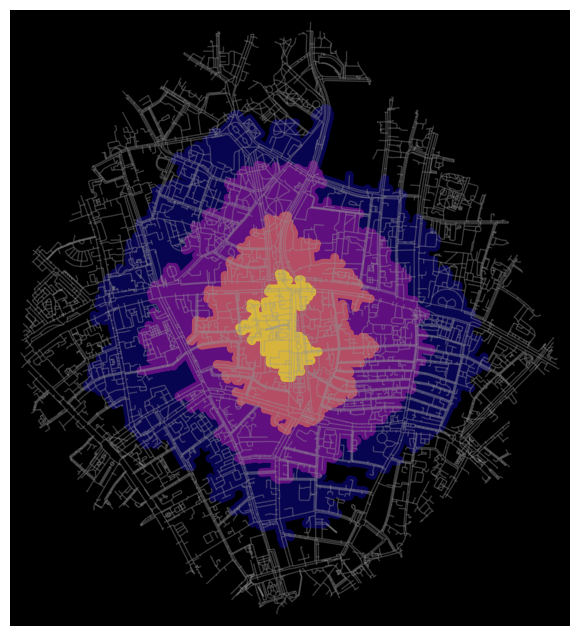

In [331]:
fig, ax = ox.plot_graph(G, show=False, close=False, edge_color='#999999', edge_alpha=0.2,
                            node_size=0, bgcolor='k')

for polygon, fc in zip(isochrones, iso_colors):
    for geom in polygon.geoms:    
        xs, ys = geom.exterior.xy 
        ax.fill(xs, ys, fc=fc, ec='none', alpha=0.6, zorder=-1)

plt.show()

In [332]:
station_isochrones[station] = isochrones

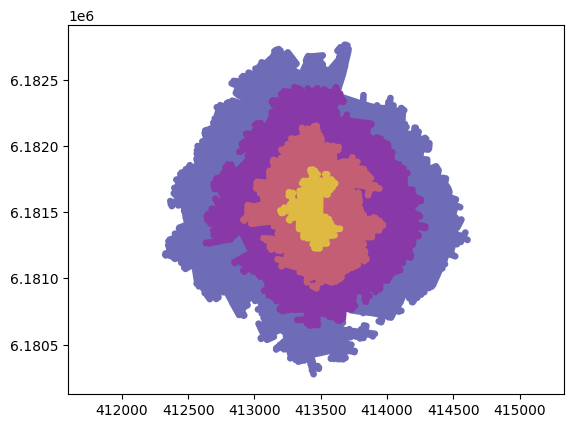

In [333]:
fig, axs = plt.subplots()
axs.set_aspect('equal', 'datalim')

for polygon, fc in zip(isochrones, iso_colors):
    for geom in polygon.geoms:    
        xs, ys = geom.exterior.xy 
        axs.fill(xs, ys, fc=fc, ec='none', alpha=0.6, zorder=-1)

plt.show()

In [334]:
station_isochrones

{'Преображенская площадь_Сокольническая линия': [<MULTIPOLYGON (((418368.713 6183733.628, 418368.408 6183734.29, 418357.258 6...>,
  <MULTIPOLYGON (((418562.414 6183924.864, 418561.376 6183927.087, 418560.562 ...>,
  <MULTIPOLYGON (((418917.82 6183898.52, 418917.059 6183898.316, 418915.901 61...>,
  <MULTIPOLYGON (((419171.151 6184131.05, 419178.133 6184131.452, 419178.831 6...>],
 'Тверская_Замоскворецкая линия': [<MULTIPOLYGON (((411557.579 6180165.072, 411557.58 6180165.076, 411557.581 6...>,
  <MULTIPOLYGON (((411761.725 6180349.69, 411761.416 6180352.124, 411761.347 6...>,
  <MULTIPOLYGON (((412762.401 6181208.189, 412763.042 6181208.316, 412763.677 ...>,
  <MULTIPOLYGON (((412354.419 6180566.446, 412353.367 6180564.229, 412352.103 ...>],
 'Белорусская_Замоскворецкая линия': [<MULTIPOLYGON (((410295.103 6181459.687, 410293.105 6181458.263, 410290.977 ...>,
  <MULTIPOLYGON (((410439.578 6181691.736, 410439.626 6181691.919, 410439.988 ...>,
  <MULTIPOLYGON (((410681.909 6182030.619,

In [335]:
mapa = [shapely.union_all([x[i] for x in list(station_isochrones.values())]) for i in range(len(trip_times))]
mapa

[<MULTIPOLYGON (((411560.29 6180175.708, 411563.595 6180189.161, 411462.133 6...>,
 <MULTIPOLYGON (((411761.52 6180357.023, 411761.931 6180359.442, 411762.577 6...>,
 <MULTIPOLYGON (((412764.245 6181208.553, 412764.808 6181208.664, 412765.458 ...>,
 <MULTIPOLYGON (((412350.639 6180560.158, 412348.989 6180558.342, 412347.169 ...>]

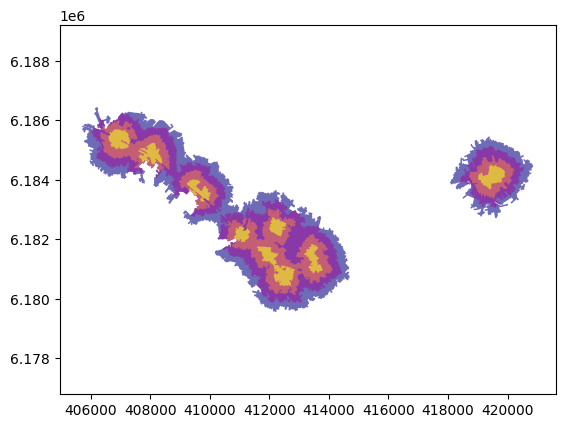

In [336]:
fig, axs = plt.subplots()
axs.set_aspect('equal', 'datalim')

for polygon, fc in zip(mapa, iso_colors):
    for geom in polygon.geoms:    
        xs, ys = geom.exterior.xy 
        axs.fill(xs, ys, fc=fc, ec='none', alpha=0.6, zorder=-1)

plt.show()